## Importing The Necessary Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
from nltk.collocations import *
from PIL import Image
from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('gazetteers')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package gazetteers to /root/nltk_data...
[nltk_data]   Unzipping corpora/gazetteers.zip.


True

## Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/My Drive/Internship CS778/reddit'

In [ ]:
#change directory to the DataViz Folder
import os
os.chdir(PATH)

In [ ]:
!ls

au_topic.csv		       COVID_AU_national.csv	  reddit_uk_label2.csv
au_topic_time.csv	       lda_tuning_results.csv	  reddit_uk_label.csv
Comments_AUtop500.csv	       lda_tuning_results.gsheet  reddit_us_label2.csv
Comments_CAtop500.csv	       reddit_au_label2.csv	  reddit_us_label.csv
Comments_Coronavirustop20.csv  reddit_au_label.csv	  test_dataset.json
Comments_globaltop50.csv       reddit_ca_label2.csv	  topic_case.csv
Comments_UKtop500.csv	       reddit_ca_label.csv	  train_dataset.json
Comments_UStop500.csv	       reddit_global_label.csv


In [ ]:
#posts = pd.read_csv('reddit_posts.csv',encoding= 'unicode_escape')
comments = pd.read_csv('au_topic_time.csv',encoding= 'unicode_escape')

In [ ]:
comments.head(3)

,Unnamed: 0,text_x,sentiment,topic1,topic2,topic3,topic4,Upvote,Time
0,0,whats story adonis security guard super thirst...,positive,0.074793,0.078727,0.083633,0.762847,14.0,2020-07-08 08:07:01
1,1,wrong thinking people company charged somethin...,negative,0.595910,0.043927,0.051215,0.308949,10.0,2020-07-08 22:10:28
2,2,would surprised many tradespeople get proposit...,positive,0.324784,0.019283,0.018631,0.637303,8.0,2020-07-08 19:44:16


As we can see from the table above, both comment and post are basical the same and contain text feature. Post is more about fact from news while comments can easily consider as the individual's opinion.It is resonable to combine them for sentiment analysis.

In [ ]:
comments.to_datetime

Unnamed: 0      int64
text_x         object
sentiment      object
topic1        float64
topic2        float64
topic3        float64
topic4        float64
Upvote        float64
Time           object
dtype: object

## Data Visualization and Preprocessing

Plot the comment number for different hours in a day. It could be used for government to reach out more young people, and also marketing campaign to get the highest response. 

In [ ]:
# convert object dtype to time
comments['Time'] = pd.to_datetime(comments['Time'], errors='coerce')

In [ ]:
# this code extract the date from the Time column
from datetime import datetime
d = datetime.now()
comments['Time_date'] = [d.date() for d in comments["Time"]]

In [ ]:
# extract the hour under the time
comments['hour'] = comments['Time'].dt.hour

Universal Time Coordinated is 10 hours behind of Australian Eastern Standard Time

In [ ]:
# extract the hour under the time
comments['month'] = comments['Time'].dt.month

In [ ]:
comments.head()

,Unnamed: 0,text_x,sentiment,topic1,topic2,topic3,topic4,Upvote,Time,month
0,0,whats story adonis security guard super thirst...,positive,0.074793,0.078727,0.083633,0.762847,14.0,2020-07-08 08:07:01,7
1,1,wrong thinking people company charged somethin...,negative,0.595910,0.043927,0.051215,0.308949,10.0,2020-07-08 22:10:28,7
2,2,would surprised many tradespeople get proposit...,positive,0.324784,0.019283,0.018631,0.637303,8.0,2020-07-08 19:44:16,7
3,3,haha let use people couple day training well k...,negative,0.377352,0.103352,0.012037,0.507259,8.0,2020-07-08 21:50:14,7
4,4,released guard worked wondering charge guard g...,positive,0.507195,0.043970,0.401287,0.047548,3.0,2020-07-08 09:44:08,7


In [ ]:
def f(x):
  y = x + 10
  if y <= 23:
    return y
  if y > 23:
    y = y -24
    return y

In [ ]:
comments['hour_au'] = comments['hour'].apply(f)

In [ ]:
comments.head()

Text(0, 0.5, 'comment number')

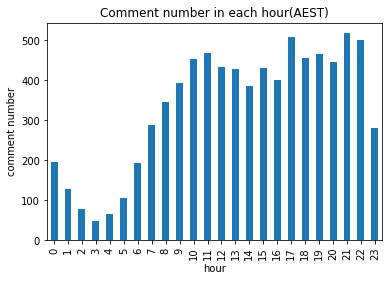

In [ ]:
# plot the bar chart
visual = comments['hour_au'].value_counts().sort_index()
ax = visual.plot.bar(title='Comment number in each hour(AEST)')
ax.set_xlabel("hour")
ax.set_ylabel("comment number")

**comment per month**

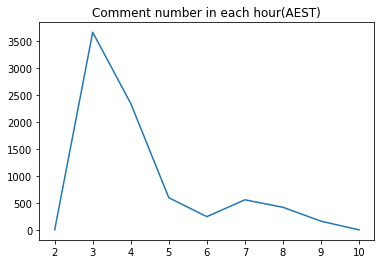

In [ ]:
# plot the bar chart comment per month
visual = comments['month'].value_counts().sort_index()
ax = visual.plot.line(title='Comment number in each hour(AEST)')

In [ ]:
df2 = comments.groupby('month')['sentiment'].value_counts()

In [ ]:
df2.name = 'count'

In [ ]:
df2 = df2.to_frame(name="count")

In [ ]:
# count the year groups
res = comments.groupby(['month', 'sentiment']).count()
res = res.reset_index()
res

**sentiment trend per month**

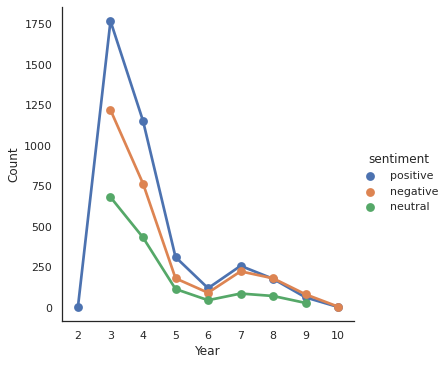

In [ ]:
# only the max values
# res_ind = res.groupby(['Year']).idxmax()
# res = res.loc[res_ind['ID'].tolist()]
# viz
sns.set(style="white")
g = sns.catplot(x='month',
                y= 'text_x',
                hue='sentiment',
                data=res,
                kind='point',
                ci=None,
                   )
g.set_axis_labels("Year", "Count")
plt.show()

Let's deal with the text

In [ ]:
# concat topic and comment together
#posts_select = posts['Title'].rename({'Title':'text'})
comments_select = comments['text_x'].rename({'text_x':'text'})
#alltext = pd.concat([posts_select,comments_select])
alltext = comments_select

Reddit allows users to edit their post and there are some replies have been deleted or removed, and it will be marked as [removed] or [deleted]. Let's get rid of those rows.

In [ ]:
#use regular expression to deal with [removed] or [deleted]
patternDel = r'\[.*?\]'
filter = alltext.str.contains(patternDel)

In [ ]:
alltext = alltext[~filter]

In [ ]:
alltext.shape

(8007,)

In [ ]:
#stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

def preprocessing(columntitle):
    
    #convert all to lower case
    columntitle = columntitle.str.lower() #
    #replace line breaks
    columntitle = columntitle.replace('\r', ' ').replace('\n', ' ')
    #replace punctuation
    columntitle = columntitle.apply(lambda x: re.sub(r'[^\w\s]', '', str(x)) )
    #remove stop word
    columntitle = columntitle.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))
    #remove link
    columntitle = columntitle.apply(lambda x: re.sub(r'\(?http\S+', '', str(x)))
    #Lemmatization 
    lemmatized = [lemmatizer.lemmatize(word) for word in columntitle]
    columntitle = columntitle.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
        ) )
    words = TweetTokenizer().tokenize(str(columntitle))
    return words  #columntitle
    

In [ ]:
#comments['text'] = comments['text_x'].apply(preprocessing)
alltext = preprocessing(alltext)

In [ ]:
#filter all len less than 1
mask = alltext.str.len() <=1
alltext = alltext[~mask]

In [ ]:
alltext = alltext.to_frame('text').reset_index(drop=True)

In [ ]:
alltext

## New EDA

In [ ]:
comments.sentiment.value_counts()

positive    3836
negative    2728
neutral     1443
Name: sentiment, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


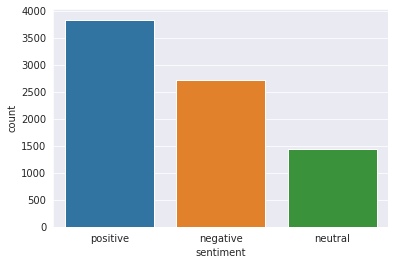

In [ ]:
sns.set_style("darkgrid")
sns.countplot(comments.sentiment)

In [ ]:
comments_count = comments.groupby('sentiment').count()
comments_count

,Unnamed: 0,text_x,topic1,topic2,topic3,topic4,Upvote,Time,Time_date,hour,month,hour_au
sentiment,,,,,,,,,,,,
negative,2728,2728,2728,2728,2728,2728,2728,2728,2728,2728,2728,2728
neutral,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443
positive,3836,3836,3836,3836,3836,3836,3836,3836,3836,3836,3836,3836


Text(0.5, 1.0, 'Sentiment Distribution')

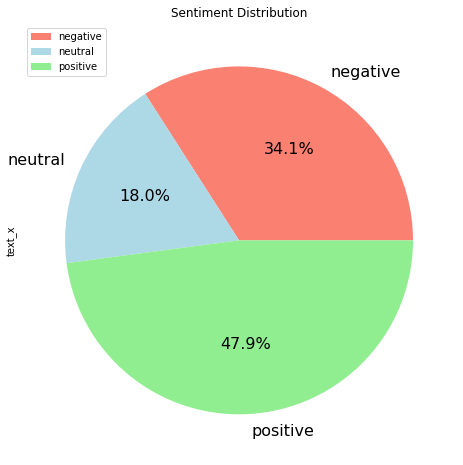

In [ ]:
#create a pie chart for sentiment distribution
colors = ['salmon','lightblue','lightgreen']
plot = comments_count.plot.pie(y='text_x',colors=colors, figsize=(8, 8),autopct="%1.1f%%"
                    ,textprops={'fontsize': 16})
plot.set_title("Sentiment Distribution")

In [ ]:
comments.isna().sum()

Unnamed: 0    0
text_x        0
sentiment     0
topic1        0
topic2        0
topic3        0
topic4        0
Upvote        0
Time          0
Time_date     0
dtype: int64

In [ ]:
import string
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
stop.update(['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said', 'im', 
                  'thing', 'its','need','still','going','one','really','even','get','would',
             'go','also'])

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
comments['text_x']=comments['text_x'].apply(denoise_text)

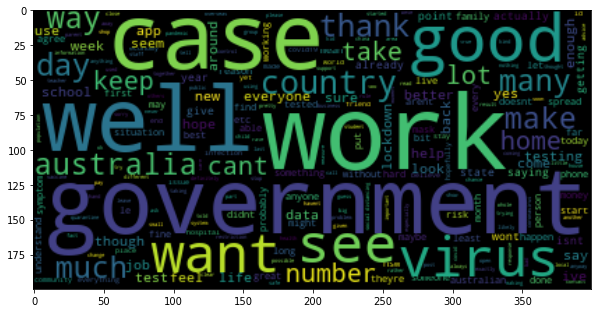

In [ ]:
plt.figure(figsize = (10,10)) # Text that is not Fake
wc = WordCloud(max_words = 500 , width = 400 , height = 200 , stopwords = STOPWORDS).generate(" ".join(comments[comments.sentiment == "positive"].text_x))
plt.imshow(wc , interpolation = 'bilinear')

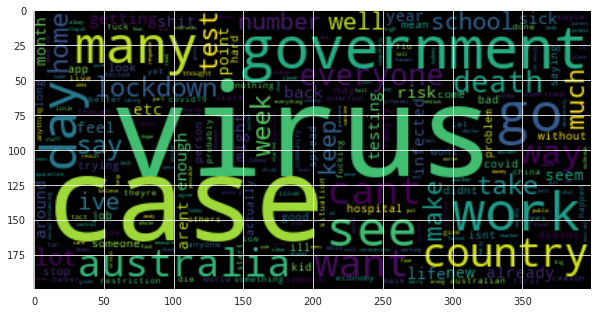

In [ ]:
plt.figure(figsize = (10,10)) # Text that is not Fake
wc = WordCloud(max_words = 500 , width = 400 , height = 200 , stopwords = STOPWORDS).generate(" ".join(comments[comments.sentiment == "negative"].text_x))
plt.imshow(wc , interpolation = 'bilinear')

**sentiment text length**

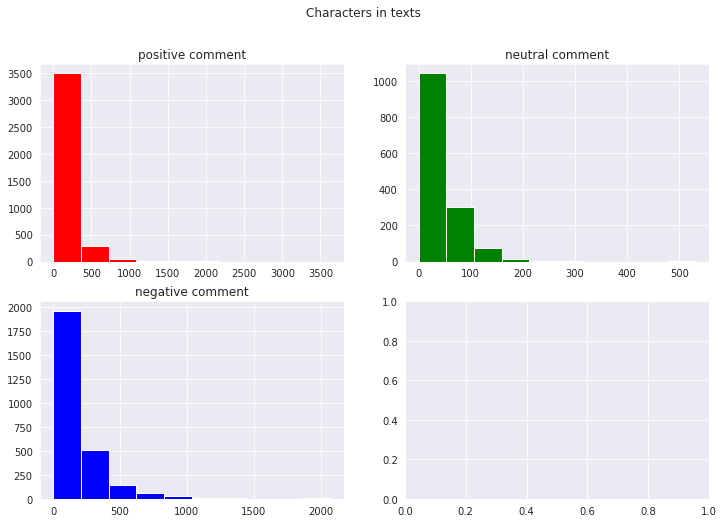

In [ ]:
fig,((ax1, ax2),(ax3, ax4))=plt.subplots(nrows=2, ncols=2,figsize=(12,8))
text_len=comments[comments['sentiment']=='positive']['text_x'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('positive comment')
text_len=comments[comments['sentiment']=='neutral']['text_x'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('neutral comment')
text_len=comments[comments['sentiment']=='negative']['text_x'].str.len()
ax3.hist(text_len,color='blue')
ax3.set_title('negative comment')
fig.suptitle('Characters in texts')
plt.show()

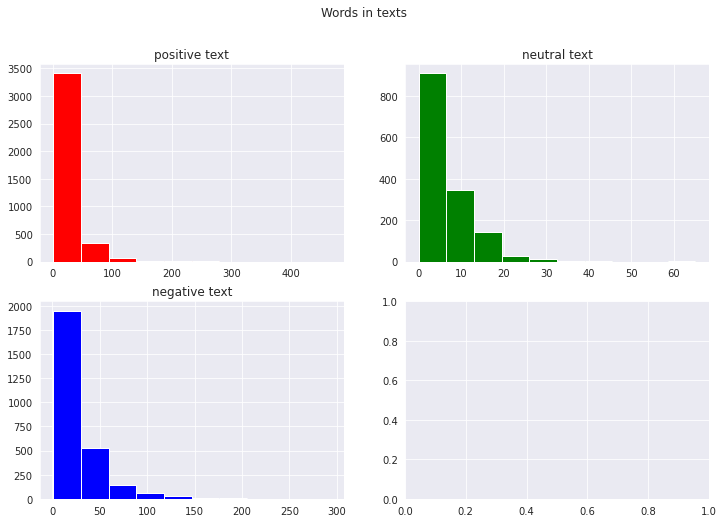

In [ ]:
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(nrows=2, ncols=2,figsize=(12,8))
text_len=comments[comments['sentiment']=='positive']['text_x'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('positive text')
text_len=comments[comments['sentiment']=='neutral']['text_x'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('neutral text')
text_len=comments[comments['sentiment']=='negative']['text_x'].str.split().map(lambda x: len(x))
ax3.hist(text_len,color='blue')
ax3.set_title('negative text')
fig.suptitle('Words in texts')
plt.show()

**word length of the sentiment**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

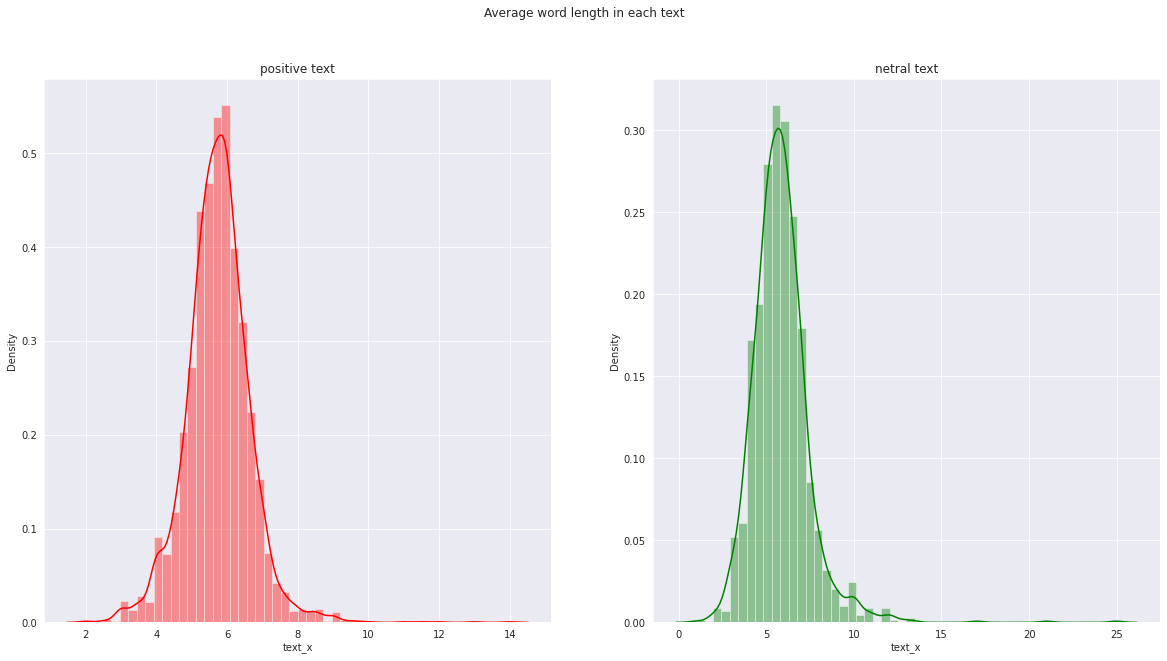

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=comments[comments['sentiment']=='positive']['text_x'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('positive text')
word=comments[comments['sentiment']=='neutral']['text_x'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('netral text')
#word=comments[comments['sentiment']=='negative']['text_x'].str.split().apply(lambda x : [len(i) for i in x])
#sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='blue')
#ax3.set_title('negative text')
fig.suptitle('Average word length in each text')

### N Gram

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(comments.text_x)
corpus[:5]

['whats', 'story', 'adonis', 'security', 'guard']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'case': 994,
 'day': 797,
 'get': 1485,
 'go': 822,
 'government': 772,
 'home': 742,
 'virus': 757,
 'week': 730,
 'work': 791,
 'would': 1192}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

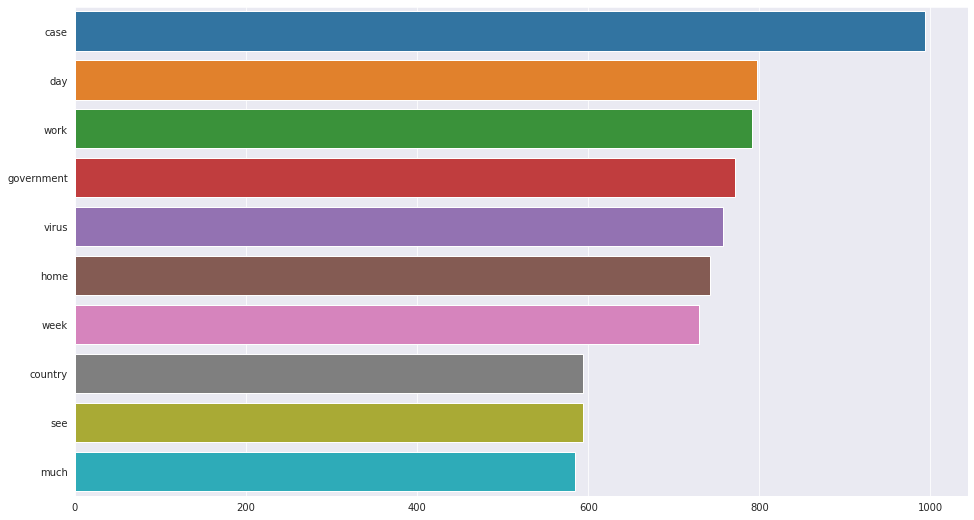

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(comments.text_x,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

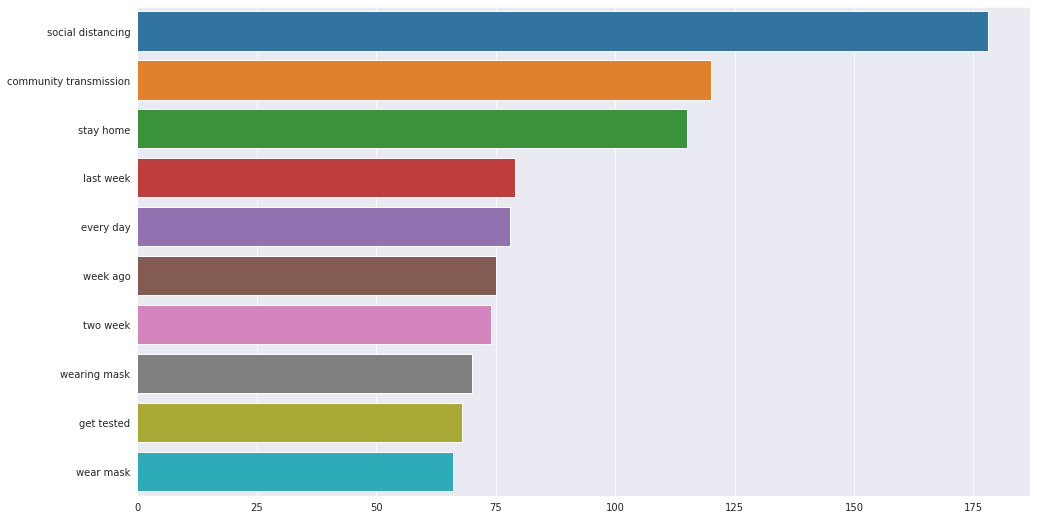

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(comments.text_x,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

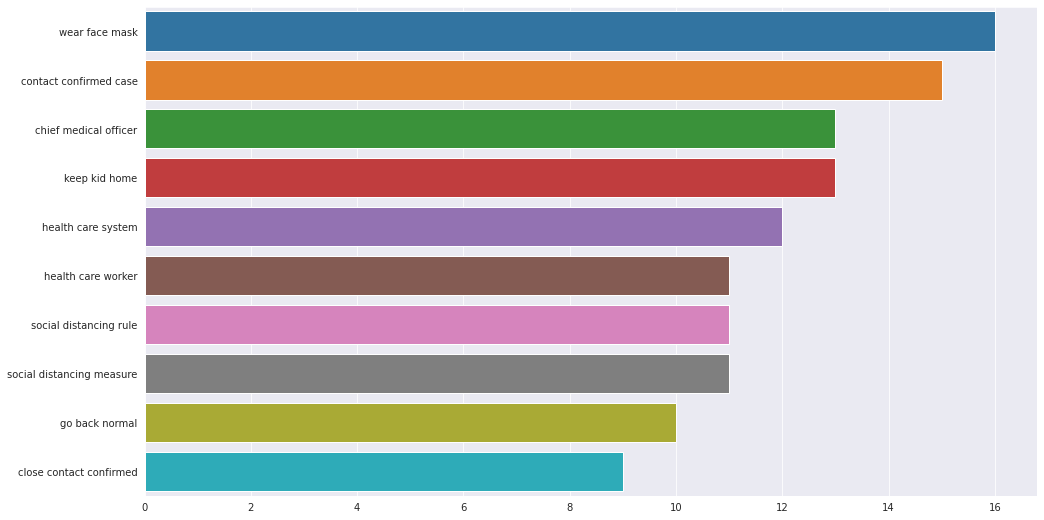

In [ ]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(comments.text_x,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

### Bigrams

In [ ]:
#use . to seperate each sentence
all_text = alltext.text.str.cat(sep='. ')

In [ ]:
# word tokenize
all_text_token = nltk.word_tokenize(all_text)

In [ ]:
#get the bigram
bigram_measures = nltk.collocations.BigramAssocMeasures()
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq) 
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

print(common_bigrams(all_text, 10, 10))

[('vice', 'versa'), ('los', 'angeles'), ('nitric', 'oxide'), ('chadox1', 'ncov19'), ('grasping', 'straw'), ('rheumatoid', 'arthritis'), ('faq', 'relating'), ('logistic', 'regression'), ('2080', 'ti'), ('pipe', 'dream')]


we can find some information from the bigram, but it doesn't make lots of sense

### Word Cloud

In [ ]:
# use reddit picture as the word cloud mask
#reddit_mask = np.array(Image.open("/content/drive/My Drive/Internship CS778/files/re2.png"))
reddit_mask = np.array(Image.open("/content/drive/My Drive/Internship CS778/files/au.jpg"))

In [ ]:
# a small tokenize function
def tokenize(text):
    # first tokenize by word 
    tokens = [word for word in nltk.word_tokenize(text)]
    tokens = [word for word in tokens if len(word)>2]
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    return tokens

In [ ]:
alltext=alltext.to_frame()

In [ ]:
alltext['text_x']

In [ ]:
from nltk.corpus import stopwords
from tqdm import tqdm
all_text_wc = alltext.text_x.apply(lambda x: tokenize(x))

In [ ]:
# create a dict to document word frequency
reddit_dict = {}

for words in all_text_wc:
    for word in words:
        if word not in reddit_dict:
            reddit_dict[word] = 1
        else:
            reddit_dict[word] += 1
            

In [ ]:
# common stop words & custom stop words
stopwords = set(STOPWORDS)
entries = ['think', 'even', 'know','like', 'im', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said', 'im', 
                  'thing', 'its','need','still','going','one','really','even','get','would',
             'go','also']

for key in entries:
    if key in reddit_dict:
        del reddit_dict[key]

(-0.5, 859.5, 852.5, -0.5)

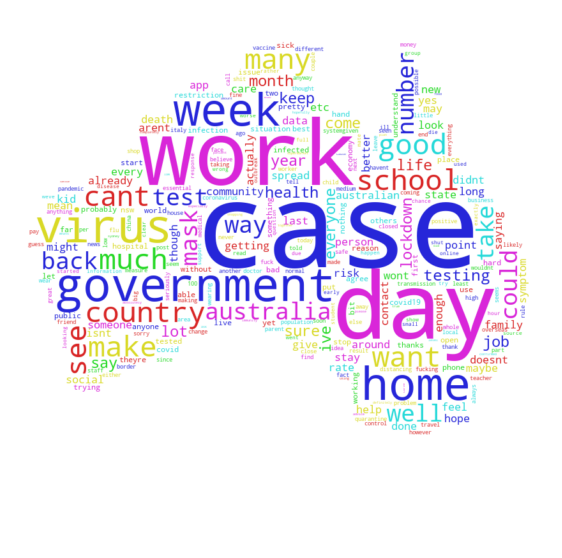

In [ ]:
#draw the word cloud
def my_tf_color_func(dictionary):
    def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(%d, 70%%, 50%%)" % (60 * dictionary[word])
    return my_tf_color_func_inner

wc = WordCloud(max_words=300, background_color="white", stopwords=stopwords, 
               mask=reddit_mask, width=860, height=860)
wc.generate_from_frequencies(frequencies=reddit_dict)
# wc.generate(full_words)
plt.figure(figsize=(10,10))
plt.imshow(wc.recolor(color_func=my_tf_color_func(reddit_dict)), interpolation="bilinear")
plt.axis("off")

(-0.5, 735.5, 1023.5, -0.5)

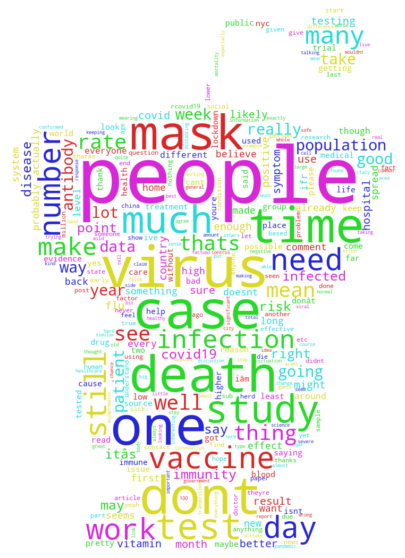

In [ ]:
#draw the word cloud
def my_tf_color_func(dictionary):
    def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(%d, 70%%, 50%%)" % (60 * dictionary[word])
    return my_tf_color_func_inner

wc = WordCloud(max_words=300, background_color="white", stopwords=STOPWORDS, 
               mask=reddit_mask, width=1000, height=800)
wc.generate_from_frequencies(frequencies=reddit_dict)
# wc.generate(full_words)
plt.figure(figsize=(20,10))
plt.imshow(wc.recolor(color_func=my_tf_color_func(reddit_dict)), interpolation="bilinear")
plt.axis("off")

As we can see from the pic that most of high frequency words are people, test,case, mask, vaccine, whihc are quite common in current pandemic situation.  

In [ ]:
alltext2 = alltext.loc[:,('text','sentiment')]

In [ ]:
alltext2.head()

,text,sentiment
0,number people coronavirus infection may dozen ...,positive
1,least 11 tested blood donor stockholm covid19 ...,negative
2,ending coronavirus lockdown will dangerous pro...,negative
3,nyc health 18 death new york city without unde...,positive
4,wearing mask protect coronavirus big mistake t...,positive


In [ ]:
alltext2.to_csv('reddit_label4.csv')